In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#import scipy
#from scipy.optimize import curve_fit
#import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, accuracy_score, recall_score, precision_score
import seaborn as sns
# import datetime
# import io
import os
import os.path
# import random
# from PIL import Image
# import tensorflow
# import albumentations as A
# import tensorflow_datasets as tfds
import tensorflow_probability as tfp
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.regularizers  import L2, L1
# from tensorflow.train import  BytesList, FloatList, Int64List
# from tensorflow.train import Example, Features, Feature
from tensorboard.plugins.hparams import api as hp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def get_directory_names(root_dir):
    directory_names = []
    for item in sorted(os.listdir(root_dir)):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            directory_names.append(item)
    return directory_names

root_directory = 'PlantDataset\Test'

directories = get_directory_names(root_directory)

print("List of directory names:")
List = []
for directory in directories:
    List.append(directory)
print(List)


List of directory names:
['Corn__common_rust', 'Corn__gray_leaf_spot', 'Corn__healthy', 'Corn__northern_leaf_blight', 'Rice__brown_spot', 'Rice__healthy', 'Rice__leaf_blast', 'Tea__algal_leaf', 'Tea__brown_blight', 'Tea__healthy', 'Tea__red_leaf_spot', 'Tomato__bacterial_spot', 'Tomato__early_blight', 'Tomato__healthy', 'Tomato__leaf_mold', 'Tomato__septoria_leaf_spot', 'Tomato__target_spot']


In [58]:
train_directory = 'PlantDataset\Train'
val_directory = 'PlantDataset\Test'
CLASS_NAME = List
CONFIGURATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 224,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 10,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE':3,
    'N_STRIDES': 1,
    'POOL_SIZE':2,
    'N_DENSE_1':1000,
    'N_DENSE_2':100,
    'NUM_CLASSES':len(List)
}

In [59]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 14509 files belonging to 17 classes.


In [60]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 3615 files belonging to 17 classes.


## Data Augmentation

In [61]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025,0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

In [13]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

In [14]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [15]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [16]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [22]:
training_dataset = (
    mixed_dataset.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)

## Dataset

In [18]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [24]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255),
])

## Data Shown

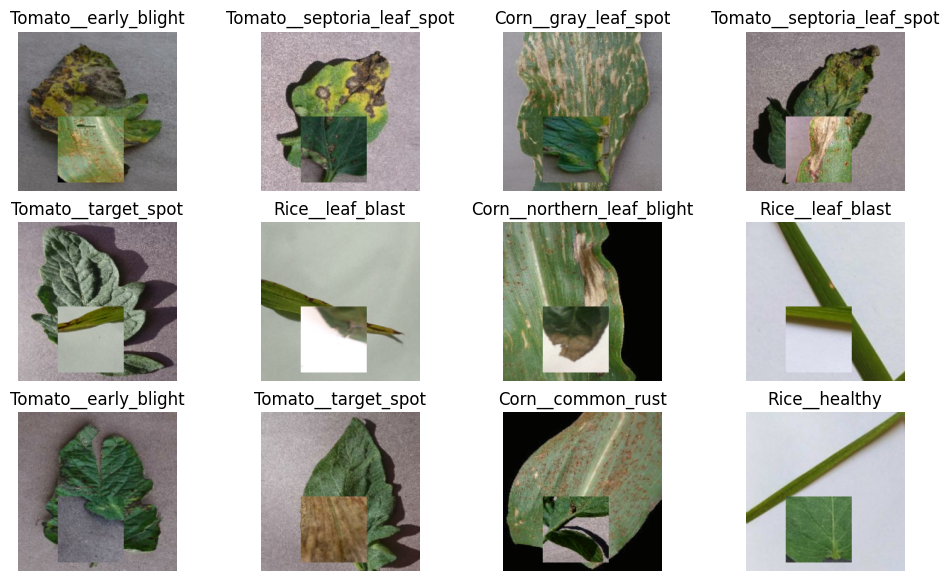

In [48]:
plt.figure(figsize = (12,7))
for images, labels in training_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')
    plt.savefig('augmented')

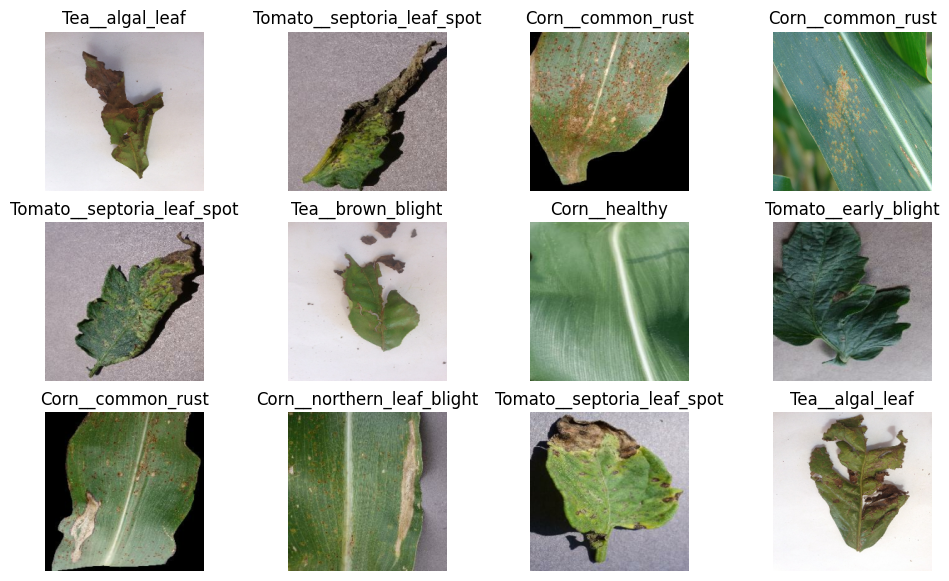

In [49]:
plt.figure(figsize = (12,7))
for images, labels in validation_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')
    plt.savefig('Data')

## ResNet50

In [ ]:
backbone = tf.keras.applications.resnet50.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
backbone.trainable = True

In [ ]:
ResNetModel = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
ResNetModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)              

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name = "accuracy")

In [ ]:
ResNetModel.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)
history1 = ResNetModel.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose= 1)

Epoch 1/10
454/454 [==============================] - 7278s 16s/step - loss: 1.2902 - accuracy: 0.7142 - val_loss: 96.2088 - val_accuracy: 0.0642
Epoch 2/10
454/454 [==============================] - 300s 652ms/step - loss: 1.1094 - accuracy: 0.7775 - val_loss: 2.8297 - val_accuracy: 0.3228
Epoch 3/10
454/454 [==============================] - 298s 648ms/step - loss: 1.0916 - accuracy: 0.7697 - val_loss: 8.6109 - val_accuracy: 0.2963
Epoch 4/10
454/454 [==============================] - 299s 650ms/step - loss: 1.0670 - accuracy: 0.7832 - val_loss: 0.9924 - val_accuracy: 0.7367
Epoch 5/10
454/454 [==============================] - 301s 656ms/step - loss: 0.9328 - accuracy: 0.8364 - val_loss: 0.5392 - val_accuracy: 0.8260
Epoch 6/10
454/454 [==============================] - 296s 644ms/step - loss: 0.9201 - accuracy: 0.8295 - val_loss: 0.6234 - val_accuracy: 0.8036
Epoch 7/10
454/454 [==============================] - 295s 641ms/step - loss: 0.8598 - accuracy: 0.8548 - val_loss: 1.9578 -

In [ ]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(ResNetModel(im))
    labels.append(label.numpy())

pred = np.argmax(predicted[:-1], axis= -1).flatten()
lab = np.argmax(labels[:-1], axis= -1).flatten()

cm = confusion_matrix(lab, pred)
#print(cm)
f1 = f1_score(lab, pred, average='micro')
#print(f1)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt=".1f")
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
ResNetModel.evaluate(validation_dataset)

113/113 [==============================] - 20s 166ms/step - loss: 0.4577 - accuracy: 0.8481


[0.45774123072624207, 0.8481327891349792]

## VGG19

In [ ]:
backbone = tf.keras.applications.vgg19.VGG19(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
backbone.trainable = True

In [ ]:
VGG19Model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
VGG19Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)              

In [ ]:
VGG19Model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)
history2 = VGG19Model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose= 1)

Epoch 1/10
454/454 [==============================] - 2670s 6s/step - loss: 2.3220 - accuracy: 0.2487 - val_loss: 4.6797 - val_accuracy: 0.0822
Epoch 2/10
454/454 [==============================] - 330s 719ms/step - loss: 2.1322 - accuracy: 0.3028 - val_loss: 8.1976 - val_accuracy: 0.1635
Epoch 3/10
454/454 [==============================] - 328s 711ms/step - loss: 2.0404 - accuracy: 0.3337 - val_loss: 7.2307 - val_accuracy: 0.0822
Epoch 4/10
454/454 [==============================] - 338s 735ms/step - loss: 1.9898 - accuracy: 0.3508 - val_loss: 1.6691 - val_accuracy: 0.4055
Epoch 5/10
454/454 [==============================] - 325s 706ms/step - loss: 1.9594 - accuracy: 0.3701 - val_loss: 7.9178 - val_accuracy: 0.1707
Epoch 6/10
454/454 [==============================] - 331s 718ms/step - loss: 1.9667 - accuracy: 0.3643 - val_loss: 3.4930 - val_accuracy: 0.1131
Epoch 7/10
454/454 [==============================] - 330s 719ms/step - loss: 1.9095 - accuracy: 0.3902 - val_loss: 11018609.0

In [ ]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(VGG19Model(im))
    labels.append(label.numpy())

# print(np.argmax(labels[:-1], axis= -1).flatten())
# print(np.argmax(predicted[:-1], axis= -1).flatten())
pred = np.argmax(predicted[:-1], axis= -1).flatten()
lab = np.argmax(labels[:-1], axis= -1).flatten()

cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True,)
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## InceptionV3

In [ ]:
backbone = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
backbone.trainable = True

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name = "accuracy")

In [ ]:
InceptionNetV3 = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
InceptionNetV3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 batch_normalization_94 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_1 (Dense)             (None, 100)              

In [ ]:
loss_function = CategoricalCrossentropy()

metrics = CategoricalAccuracy(name = "accuracy")

InceptionNetV3.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)
history3 = InceptionNetV3.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose= 1)

Epoch 1/10
454/454 [==============================] - 5490s 12s/step - loss: 1.2944 - accuracy: 0.6944 - val_loss: 8526.6416 - val_accuracy: 0.0822
Epoch 2/10
454/454 [==============================] - 311s 676ms/step - loss: 1.2382 - accuracy: 0.7035 - val_loss: 531.1652 - val_accuracy: 0.3989
Epoch 3/10
454/454 [==============================] - 311s 673ms/step - loss: 1.0200 - accuracy: 0.7909 - val_loss: 29.2383 - val_accuracy: 0.4254
Epoch 4/10
454/454 [==============================] - 309s 673ms/step - loss: 1.0104 - accuracy: 0.7868 - val_loss: 23.5506 - val_accuracy: 0.3817
Epoch 5/10
454/454 [==============================] - 309s 671ms/step - loss: 1.0170 - accuracy: 0.7895 - val_loss: 1.5714 - val_accuracy: 0.7021
Epoch 6/10
454/454 [==============================] - 309s 672ms/step - loss: 0.9228 - accuracy: 0.8253 - val_loss: 24.9887 - val_accuracy: 0.5743
Epoch 7/10
454/454 [==============================] - 308s 667ms/step - loss: 0.8642 - accuracy: 0.8407 - val_loss: 1

[[246   0   0  12   1   0   0   0   0   0   0   0   1   0   0   0   0]
 [  3  95   1  92   2   0   0   0   0   0   1  21   0   1   0   0   0]
 [  0   0 232   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   5 228   0   0   0   0   0   0   0   1   2   2   0   0   0]
 [  0   0   0   0  83  36  11   0   0   0   0   0   0   0   0   0   0]
 [  0   0   5   0   3 276   2   0   0   1   4   0   0   0   0   0   0]
 [  0   0   1   0  43  57  92   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1  19   0   0  47   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   1  30   0  34   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   0  39   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  85   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   0   0   0 418   2   1   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0 186   6   4   0   3]
 [  0   0   1   1   0   0   0   0   0   0   0   0   0 315   0   0   0]
 [  0 

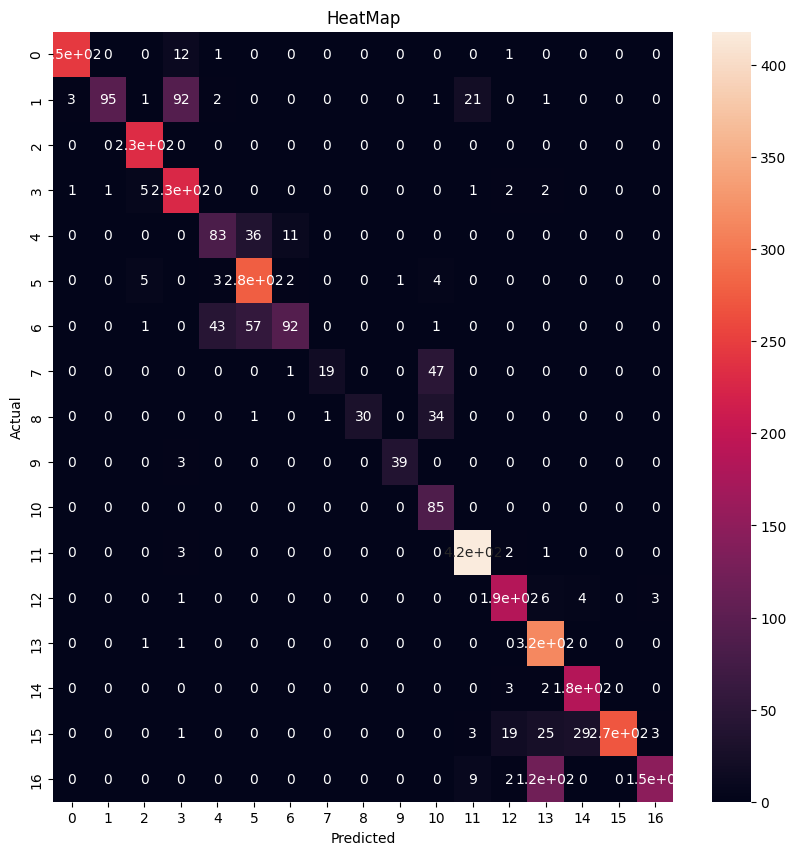

In [ ]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(InceptionNetV3(im))
    labels.append(label.numpy())

# print(np.argmax(labels[:-1], axis= -1).flatten())
# print(np.argmax(predicted[:-1], axis= -1).flatten())
pred = np.argmax(predicted[:-1], axis= -1).flatten()
lab = np.argmax(labels[:-1], axis= -1).flatten()

cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True,)
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## DenseNet121

In [ ]:
backbone = tf.keras.applications.densenet.DenseNet121(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
backbone.trainable = True

In [ ]:
DenseNet = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
DenseNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1000)              1025000   
                                                                 
 batch_normalization_95 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
loss_function = CategoricalCrossentropy()

metrics = CategoricalAccuracy(name = "accuracy")

DenseNet.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)
history4 = DenseNet.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose= 1)

Epoch 1/10
454/454 [==============================] - 411s 729ms/step - loss: 1.1197 - accuracy: 0.7771 - val_loss: 1.2318 - val_accuracy: 0.6127
Epoch 2/10
454/454 [==============================] - 326s 710ms/step - loss: 0.8460 - accuracy: 0.8556 - val_loss: 0.4268 - val_accuracy: 0.8526
Epoch 3/10
454/454 [==============================] - 325s 708ms/step - loss: 0.7488 - accuracy: 0.8812 - val_loss: 0.7720 - val_accuracy: 0.7447
Epoch 4/10
454/454 [==============================] - 326s 708ms/step - loss: 0.7030 - accuracy: 0.8887 - val_loss: 0.2878 - val_accuracy: 0.9162
Epoch 5/10
454/454 [==============================] - 323s 703ms/step - loss: 0.6570 - accuracy: 0.9031 - val_loss: 0.2995 - val_accuracy: 0.9026
Epoch 6/10
454/454 [==============================] - 324s 706ms/step - loss: 0.6378 - accuracy: 0.9112 - val_loss: 0.3000 - val_accuracy: 0.8952
Epoch 7/10
454/454 [==============================] - 320s 696ms/step - loss: 0.6197 - accuracy: 0.9184 - val_loss: 0.4176 -

[[248   2   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3 132   0  81   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 230   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  4   4   1 227   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  79  23  20   7   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   5 280   3   5   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0  19  26 139   7   5   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  66   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  67   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  51   5   0  29   0   0   0   0   0   0]
 [  0   3   0   2   0   0   0   1   0   0   0 280   1  21   0  25  91]
 [  0   1   0   1   0   0   0   0   0   0   0   0 112   3   7  21  54]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0 315   0   0   0]
 [  0 

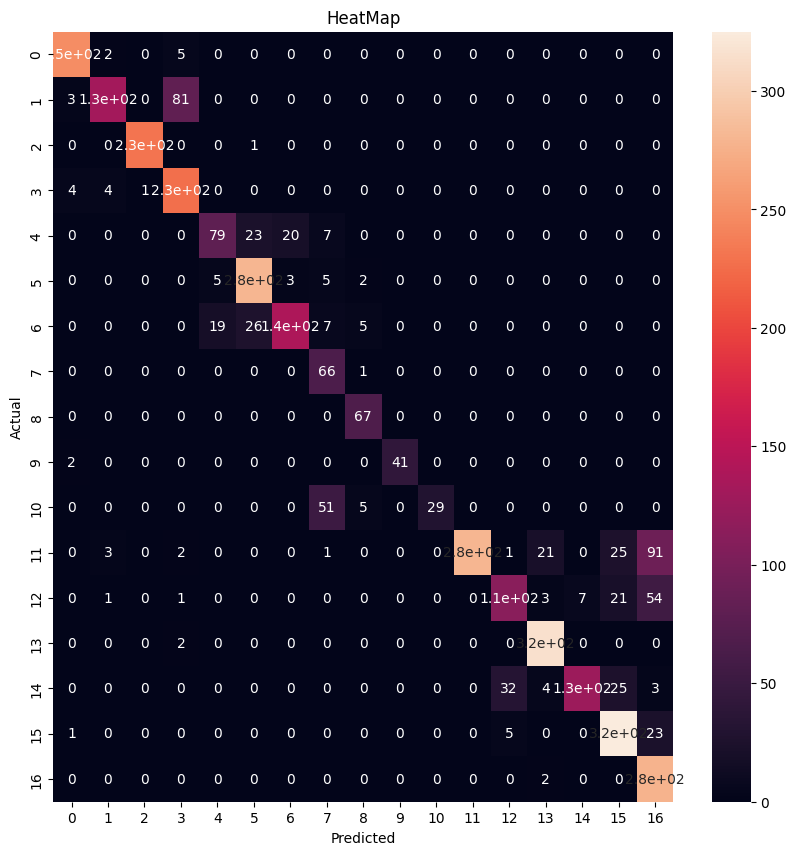

In [ ]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(DenseNet(im))
    labels.append(label.numpy())

# print(np.argmax(labels[:-1], axis= -1).flatten())
# print(np.argmax(predicted[:-1], axis= -1).flatten())
pred = np.argmax(predicted[:-1], axis= -1).flatten()
lab = np.argmax(labels[:-1], axis= -1).flatten()

cm = confusion_matrix(lab, pred)
print(cm)


plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True,)
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
f1 = f1_score(lab, pred)
print(f1)

0.8137108792846498


## Proposed Model

In [36]:
ReducedPlantDiseaseDetection = tf.keras.Sequential([
    InputLayer(input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    resize_rescale_layers,
    Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu"),
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
])

ReducedPlantDiseaseDetection.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 111, 111, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 55, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 55, 55, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 1000)           │         4,00

 Total params: 2,195,617 (8.38 MB)

 Trainable params: 2,191,601 (8.36 MB)

 Non-trainable params: 4,016 (15.69 KB)

In [39]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


ReducedPlantDiseaseDetection.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]), 
                                     loss=loss_function, 
                                     metrics=metrics)

PlantDisease = ReducedPlantDiseaseDetection.fit(training_dataset,
                                                validation_data=validation_dataset,
                                                epochs=CONFIGURATION["N_EPOCHS"],
                                                verbose=1,
                                                callbacks=[early_stopping_callback])

Epoch 1/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 219s 463ms/step - accuracy: 0.8274 - loss: 0.7926 - val_accuracy: 0.7828 - val_loss: 0.6008
Epoch 2/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 209s 452ms/step - accuracy: 0.8756 - loss: 0.8012 - val_accuracy: 0.7806 - val_loss: 0.7615
Epoch 3/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 215s 467ms/step - accuracy: 0.8872 - loss: 0.7578 - val_accuracy: 0.8094 - val_loss: 0.5633
Epoch 4/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 210s 454ms/step - accuracy: 0.8873 - loss: 0.7339 - val_accuracy: 0.7206 - val_loss: 0.8446
Epoch 5/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 244s 530ms/step - accuracy: 0.8921 - loss: 0.7480 - val_accuracy: 0.8235 - val_loss: 0.6030
Epoch 6/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 228s 495ms/step - accuracy: 0.8944 - loss: 0.7449 - val_accuracy: 0.7142 - val_loss: 1.0276
Epoch 7/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 231s 499ms/step - accuracy: 0.8962 - loss: 0.7119 - val_accuracy: 0.8606 - val_loss: 0.4433
Epoch 8/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 252s 548ms/step - accuracy: 0.9002 -

In [77]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(ReducedPlantDiseaseDetection(im))
    labels.append(label.numpy())

# print(np.argmax(labels[:-1], axis=-1).flatten())
# print(np.argmax(predicted[:-1], axis=-1).flatten())
pred = np.argmax(predicted[:-1], axis=-1).flatten()
lab = np.argmax(labels[:-1], axis=-1).flatten()


In [81]:
pred = np.array(pred)
lab = np.array(lab)

accuracy = accuracy_score(lab, pred)
precision = precision_score(lab, pred, average='weighted')
recall = recall_score(lab, pred, average='weighted')
f1 = f1_score(lab, pred, average='weighted')
conf_matrix = confusion_matrix(lab, pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion matrix:")
print(conf_matrix)


Accuracy: 0.8602120535714286
Precision: 0.8800704152068249
Recall: 0.8602120535714286
F1-score: 0.8535356269477118
Confusion matrix:
[[249   2   0   5   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  4 199   0  13   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0 229   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6  32   3 195   0   0   1   0   0   0   0   2   1   0   0   0   0]
 [  0   0   0   0  79  46   5   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0  12 277   6   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  28 126  41   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  67   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  66   0   0   0   0   0   0   0   0]
 [  0   3   4   0   0   0   0   0   0  34   0   0   0   0   2   1   0]
 [  0   0   0   0   0   4   0   0   0   0  81   0   0   0   0   0   0]
 [  2   0   0   1   0   0   0   0   0   0   0 404  13   0   1   0   0]
 [  1   0   0  

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, fmt='d', annot=True,)
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusionmatrix')
plt.show()

In [ ]:
plt.plot(PlantDisease.history['loss'])
plt.plot(PlantDisease.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training_loss','val_loss'])
plt.show()

In [ ]:
plt.plot(PlantDisease.history['accuracy'])
plt.plot(PlantDisease.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training_accuracy','val_accuracy'])
plt.show()

In [40]:
ReducedPlantDiseaseDetection.evaluate(validation_dataset)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.8737 - loss: 0.4349


[0.44332489371299744, 0.8605809211730957]

In [56]:
ReducedPlantDiseaseDetection.save('ReducedPlantDiseaseDetection.h5')

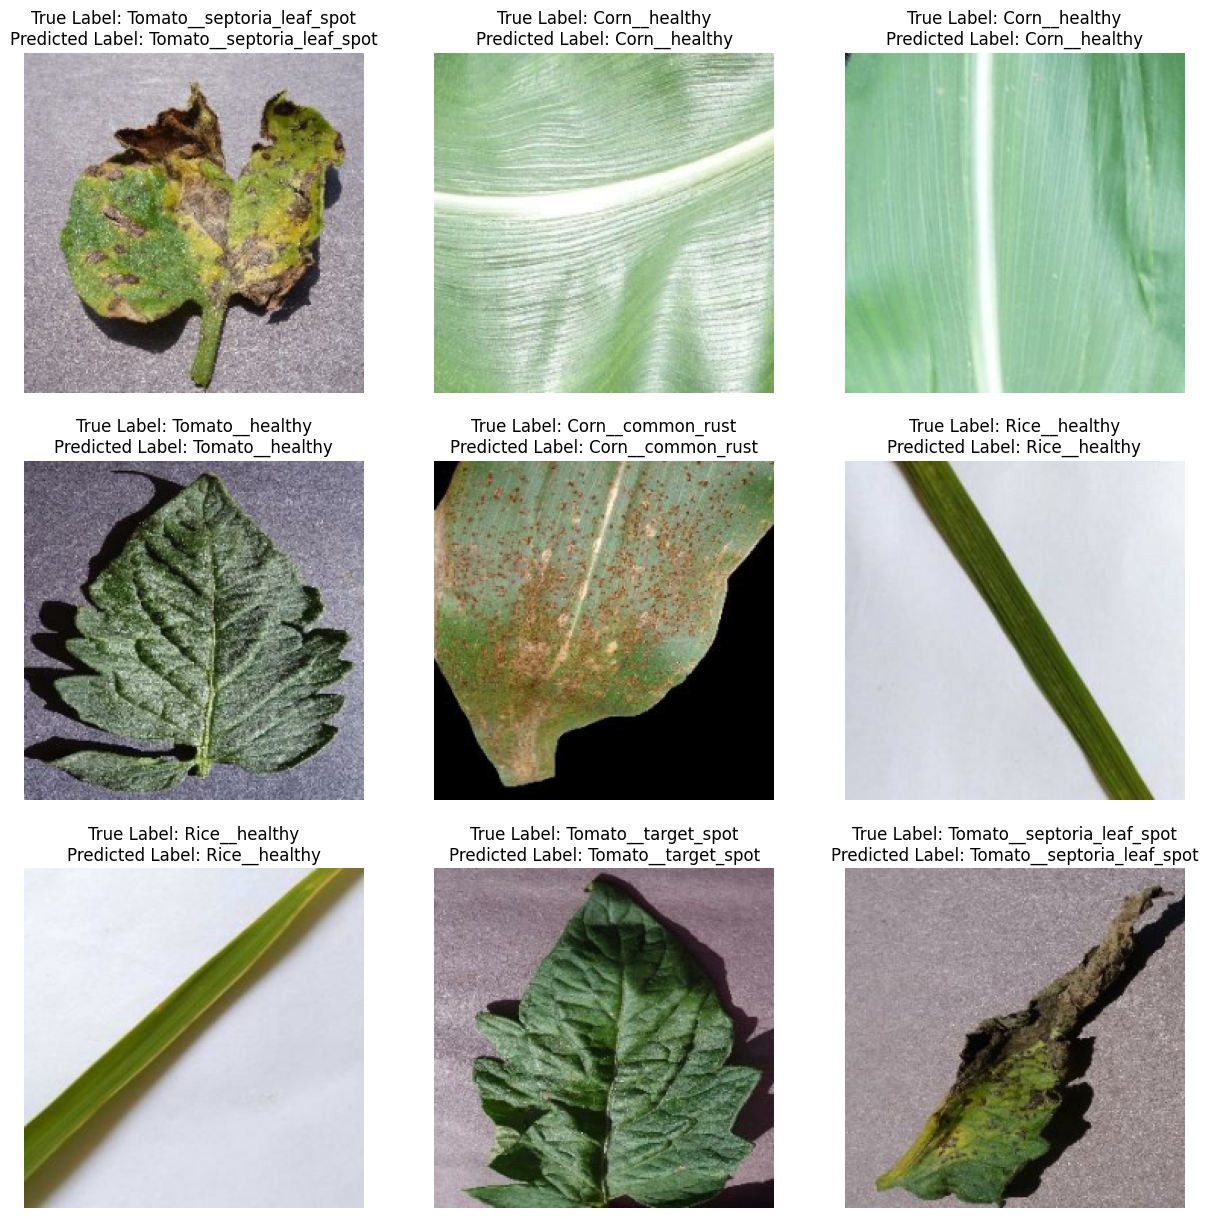

In [50]:
plt.figure(figsize = (15,15))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i]/255.)
    plt.title('True Label: ' + CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()] + '\n' + 'Predicted Label: ' +
              CLASS_NAME[tf.argmax(ReducedPlantDiseaseDetection(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis('off')
    plt.savefig('Testing')